In [54]:
import keras
keras.__version__

'2.2.5'

# Classifying newswires: a multi-class classification example


In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.


In [0]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [56]:
len(train_data)

8982

In [57]:
len(test_data)

2246

### Class weight distribution


In [58]:
import numpy
classes, count = numpy.unique(train_labels, return_counts=True)
classes=classes.reshape(-1,1)
count=count.reshape(-1,1)
print(numpy.concatenate((classes,count), axis=1))

[[   0   55]
 [   1  432]
 [   2   74]
 [   3 3159]
 [   4 1949]
 [   5   17]
 [   6   48]
 [   7   16]
 [   8  139]
 [   9  101]
 [  10  124]
 [  11  390]
 [  12   49]
 [  13  172]
 [  14   26]
 [  15   20]
 [  16  444]
 [  17   39]
 [  18   66]
 [  19  549]
 [  20  269]
 [  21  100]
 [  22   15]
 [  23   41]
 [  24   62]
 [  25   92]
 [  26   24]
 [  27   15]
 [  28   48]
 [  29   19]
 [  30   45]
 [  31   39]
 [  32   32]
 [  33   11]
 [  34   50]
 [  35   10]
 [  36   49]
 [  37   19]
 [  38   19]
 [  39   24]
 [  40   36]
 [  41   30]
 [  42   13]
 [  43   21]
 [  44   12]
 [  45   18]]


### Clearly the data is imbalanced.

# Similarily, we take a look at test labels distributions.

In [59]:
classes, count = numpy.unique(test_labels, return_counts=True)
classes=classes.reshape(-1,1)
count=count.reshape(-1,1)
print(numpy.concatenate((classes,count), axis=1))

[[  0  12]
 [  1 105]
 [  2  20]
 [  3 813]
 [  4 474]
 [  5   5]
 [  6  14]
 [  7   3]
 [  8  38]
 [  9  25]
 [ 10  30]
 [ 11  83]
 [ 12  13]
 [ 13  37]
 [ 14   2]
 [ 15   9]
 [ 16  99]
 [ 17  12]
 [ 18  20]
 [ 19 133]
 [ 20  70]
 [ 21  27]
 [ 22   7]
 [ 23  12]
 [ 24  19]
 [ 25  31]
 [ 26   8]
 [ 27   4]
 [ 28  10]
 [ 29   4]
 [ 30  12]
 [ 31  13]
 [ 32  10]
 [ 33   5]
 [ 34   7]
 [ 35   6]
 [ 36  11]
 [ 37   2]
 [ 38   3]
 [ 39   5]
 [ 40  10]
 [ 41   8]
 [ 42   3]
 [ 43   6]
 [ 44   5]
 [ 45   1]]


Clealy, test labels follow similar distribution as train labels. Class labels 1,3 and 4 have highest distributions along with some other classes in 20s.

As with the IMDB reviews, each example is a list of integers (word indices):

In [60]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Example of actual sentence obtained from reverse indexing.

In [0]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [62]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [63]:
train_labels[10]

3

## Preparing the data

Creating a sparse input matrix by marking the words present as 1. this will be input to our Dense neural network. We will limit maximum dimesions to 10000 as we have loaded only 10000 maximum frequncy words from the datasets. We donot create any embedding layer and encode words here.

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [0]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [0]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network
# Two dense hidden layers with tanh function: we start with a two layer network with 64 units and tanh actiavtion function. Since, we require probablities of classes at results we use softmax. Optimizer used is RMS prop and metrics for evaluating model is accuracy and categorical loss.

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(46, activation='softmax'))

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [70]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 173us/step - loss: 2.2891 - acc: 0.5193 - val_loss: 1.6019 - val_acc: 0.6410
Epoch 2/20
7982/7982 [==============================] - 1s 128us/step - loss: 1.3283 - acc: 0.7169 - val_loss: 1.2471 - val_acc: 0.7230
Epoch 3/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.9925 - acc: 0.7944 - val_loss: 1.0723 - val_acc: 0.7750
Epoch 4/20
7982/7982 [==============================] - 1s 128us/step - loss: 0.7672 - acc: 0.8538 - val_loss: 0.9703 - val_acc: 0.7950
Epoch 5/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.5986 - acc: 0.8939 - val_loss: 0.8969 - val_acc: 0.8040
Epoch 6/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.4688 - acc: 0.9168 - val_loss: 0.8549 - val_acc: 0.8210
Epoch 7/20
7982/7982 [==============================] - 1s 130us/step - loss: 0.3673 - acc: 0.9345 - val_loss: 0.8515 - val_acc: 0.8060


Let's display its loss and accuracy curves:

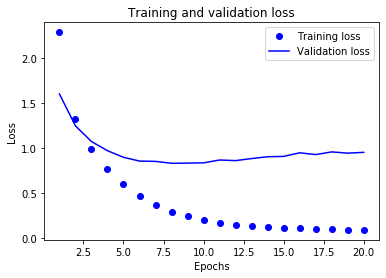

In [71]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

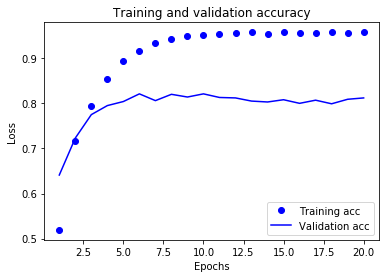

In [80]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 6 epochs. Let's train a new network from scratch for 6 epochs, then let's evaluate it on


In [81]:
model = models.Sequential()
model.add(layers.Dense(64, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=6,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/6
7982/7982 [==============================] - 2s 193us/step - loss: 2.3115 - acc: 0.5551 - val_loss: 1.5820 - val_acc: 0.6620
Epoch 2/6
7982/7982 [==============================] - 1s 132us/step - loss: 1.3309 - acc: 0.7140 - val_loss: 1.2407 - val_acc: 0.7310
Epoch 3/6
7982/7982 [==============================] - 1s 131us/step - loss: 1.0006 - acc: 0.7899 - val_loss: 1.0607 - val_acc: 0.7800
Epoch 4/6
7982/7982 [==============================] - 1s 131us/step - loss: 0.7766 - acc: 0.8449 - val_loss: 0.9583 - val_acc: 0.8020
Epoch 5/6
7982/7982 [==============================] - 1s 132us/step - loss: 0.6114 - acc: 0.8826 - val_loss: 0.8966 - val_acc: 0.8150
Epoch 6/6
2246/2246 [==============================] - 0s 109us/step


In [82]:
results

[0.9275175208824613, 0.7898486198215535]


#### Conclusion: 
Our approach reaches an accuracy of ~78% . It is a sligt improvement over our baseline of ~77%.